##Import Data

In [1]:
!pip install qiskit==0.46.1 qiskit-aer qiskit_machine_learning==0.7.2 pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of qiskit-aer to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from IPython.display import clear_output
import qiskit
from qiskit import Aer
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliSumOp, StateFn
from qiskit.algorithms.optimizers import COBYLA, ADAM, QNSPSA, AQGD
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.visualization import circuit_drawer
from scipy.optimize import minimize
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE


<ipython-input-2-a41e98793c8f>:15: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed in Qiskit 1.0. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import PauliSumOp, StateFn
<ipython-input-2-a41e98793c8f>:16: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed in Qiskit 1.0. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, ADAM, QNSPSA, AQGD


In [3]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1ec7o8uxf1w2BPAWFFzod1ICLhvX8Uuvn')
df.head()


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


##1. Data Understanding

In [4]:
df.shape

(200, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [6]:
df[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']].describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [7]:
df.Drug.value_counts()

,count
Drug,
DrugY,91
drugX,54
drugA,23
drugC,16
drugB,16


##2. Cleaning Data

In [8]:
df.isnull().sum()

,0
Age,0
Sex,0
BP,0
Cholesterol,0
Na_to_K,0
Drug,0


In [9]:
df.duplicated().sum()

0

In [10]:
# Menampilkan contoh baris duplikat
# duplicates = df[df.duplicated()]
# print(duplicates.head())

In [11]:
# df = df.drop_duplicates()
# print("Jumlah baris setelah menghapus duplikasi:", len(df))


##3. Exploratory Data Analysis (EDA)

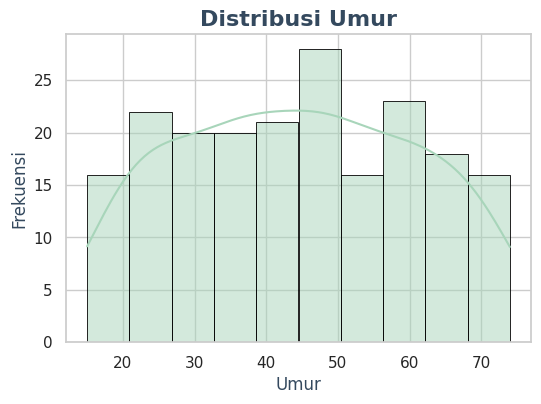

In [12]:
sns.set(style='whitegrid')
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x='Age', bins=10, kde=True, color='#A8D5BA', edgecolor='black', linewidth=0.6)

plt.title('Distribusi Umur', fontsize=16, fontweight='bold', color='#34495E')
plt.xlabel('Umur',fontsize=12, color='#34495E')
plt.ylabel('Frekuensi',fontsize=12, color='#34495E')
plt.show()


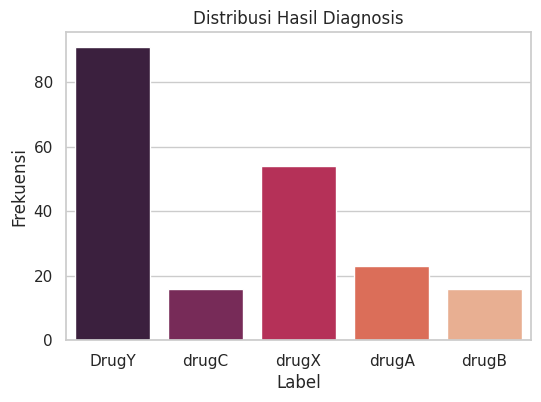

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Drug', hue='Drug', palette='rocket', legend=False)

plt.title('Distribusi Hasil Diagnosis')
plt.xlabel('Label')
plt.ylabel('Frekuensi')
plt.show()

##4. Preparation Data

In [14]:
# Data Encoding
encoder = {
    col: LabelEncoder().fit(df[col])
    for col in ['Sex', 'BP', 'Cholesterol']
}

for col, encoder in encoder.items():
    df[col] = encoder.transform(df[col])

df['Drug'] = encoder.fit_transform(df['Drug'])

In [15]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,0
1,47,1,1,0,13.093,3
2,47,1,1,0,10.114,3
3,28,0,2,0,7.798,4
4,61,0,1,0,18.043,0


In [16]:
# Filter hanya binary class (0 dan 1)
feature_df = df[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']]

x = np.array(feature_df)
y = np.array(df['Drug'])

# indexs = np.array([i for (i, s) in enumerate(y) if (s == 0 or s == 1)])
# x = x[indexs]
# y = 2 * y[indexs] - 1

print("x shape:", x.shape)
print("y shape:", y.shape)

x shape: (200, 5)
y shape: (200,)


In [17]:
def plot_resampling_results(y_resampled, title):
    plt.figure(figsize=(6, 4))
    pd.Series(y_resampled).value_counts().plot.pie(autopct='%1.1f%%', startangle=90, color='skyblue')
    plt.title(title)
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You ca

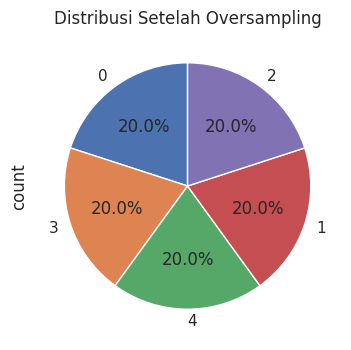

In [18]:
smote = SMOTE(random_state=42, n_jobs=-1, k_neighbors=5)
x_smote, y_smote = smote.fit_resample(x, y)

plot_resampling_results(y_smote, 'Distribusi Setelah Oversampling')

In [19]:
y_rus_series = pd.Series(y_smote)
y_rus_series.value_counts()

,count
0,91
3,91
4,91
1,91
2,91


In [20]:
pt = PowerTransformer(method='yeo-johnson')
X_pt = pt.fit_transform(x_smote)

In [21]:
# Standarisasi data
mm = MinMaxScaler()
X = mm.fit_transform(X_pt)

In [22]:
# Split train test set (80:20)
x_train, x_test, y_train, y_test = train_test_split(X, y_smote, test_size=0.2, random_state=42)

##5. QSVM Model

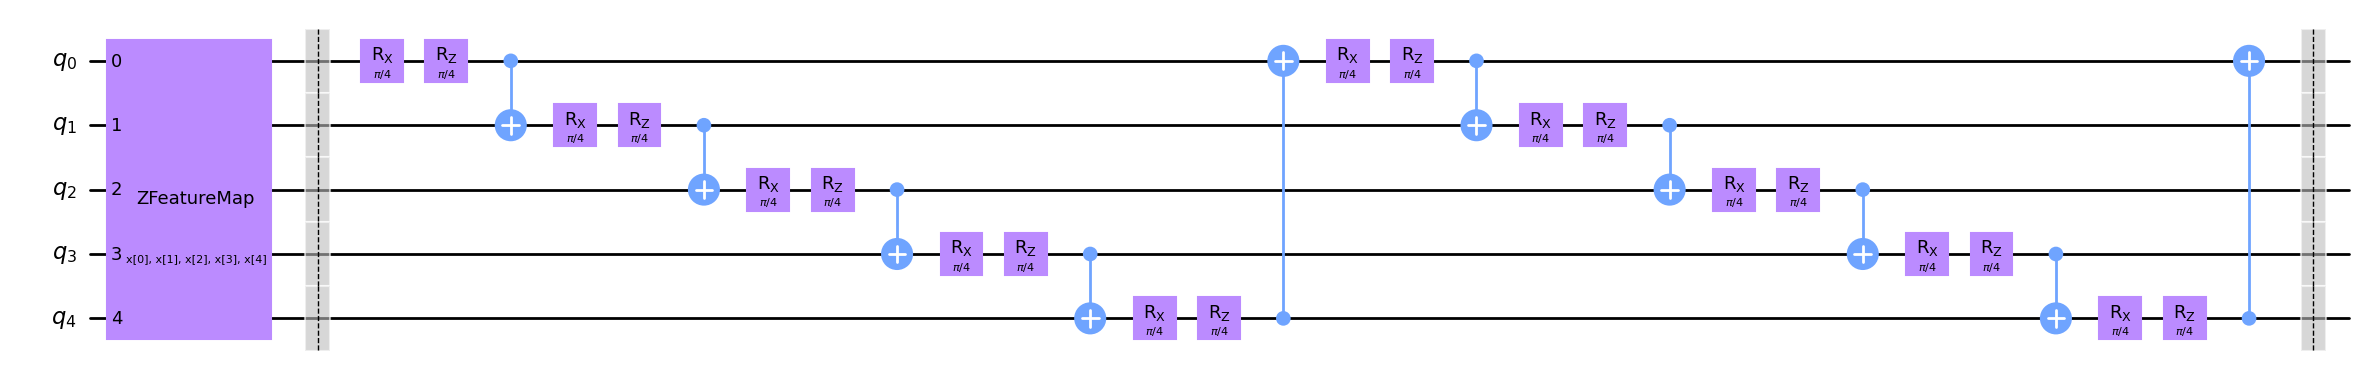

In [23]:
num_qubits = 5  # Sesuaikan dengan jumlah fitur
qc = QuantumCircuit(num_qubits)
pi = ParameterVector('Φ', num_qubits)

# Feature Map
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2)
qc.append(feature_map, range(num_qubits))
qc.barrier()

# Ansatz
depth = 2
for _ in range(depth):
    for i in range(num_qubits - 1):
        qc.rx(np.pi / 4, i)
        qc.rz(np.pi / 4, i)
        qc.cx(i, i + 1)
    qc.rx(np.pi / 4, num_qubits - 1)
    qc.rz(np.pi / 4, num_qubits - 1)
    qc.cx(num_qubits - 1, 0)
qc.barrier()

# Loss Function
def loss_function(params, circuit):
    bound_circuit = circuit
    quantum_kernel = FidelityQuantumKernel(feature_map=bound_circuit)
    fidelity_matrix = quantum_kernel.evaluate(x_train[:5], x_train[:5])
    return -np.mean(fidelity_matrix)

initial_params = []

result = minimize(
    loss_function,
    initial_params,
    args=(qc),
    method='COBYLA',
    options={'maxiter': 100}
)

optimized_params = result.x if result.success else []
optimized_circuit = qc

quantum_kernel = FidelityQuantumKernel(feature_map=optimized_circuit)

qsvc = QSVC(quantum_kernel=quantum_kernel)

# Plot Circuit
circuit_drawer(optimized_circuit, output='mpl', style='clifford', fold=100)

In [24]:
# Training
backend = Aer.get_backend('qasm_simulator')
start = time.time()
qsvc.fit(x_train, y_train)
elapsed = time.time() - start

print(f"Training time : {round(elapsed)} seconds")

<ipython-input-24-22e218479f6d>:2: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  backend = Aer.get_backend('qasm_simulator')


Training time : 743 seconds


In [25]:
y_pred_train_qsvc = qsvc.predict(x_train)
y_pred_test_qsvc = qsvc.predict(x_test)

print("Training : ")
qsvc_acc_train = accuracy_score(y_train, y_pred_train_qsvc)
print(classification_report(y_train, y_pred_train_qsvc))
print('Akurasi : {:.2f}%'.format(qsvc_acc_train * 100))

print("Testing : ")
qsvc_acc_test = accuracy_score(y_test, y_pred_test_qsvc)
print(classification_report(y_test, y_pred_test_qsvc))
print('Akurasi : {:.2f}%'.format(qsvc_acc_test * 100))

Training : 
              precision    recall  f1-score   support

           0       0.99      0.93      0.96        72
           1       0.99      1.00      0.99        73
           2       0.96      1.00      0.98        72
           3       0.99      1.00      0.99        76
           4       1.00      0.99      0.99        71

    accuracy                           0.98       364
   macro avg       0.98      0.98      0.98       364
weighted avg       0.98      0.98      0.98       364

Akurasi : 98.35%
Testing : 
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        19
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00        15
           4       0.91      1.00      0.95        20

    accuracy                           0.98        91
   macro avg       0.98      0.98      0.98        91
weighted avg       0.98      0.98    

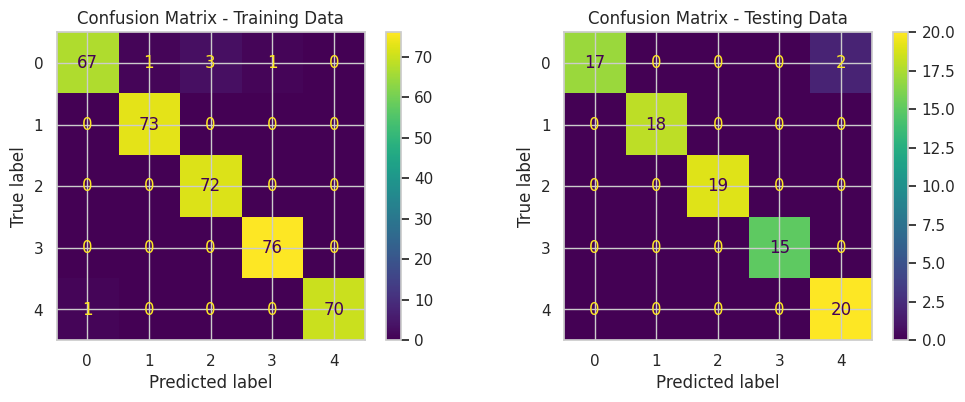

In [42]:
cm_tr = confusion_matrix(y_train, y_pred_train_qsvc)
disp_tr = ConfusionMatrixDisplay(confusion_matrix=cm_tr)
cm_ts = confusion_matrix(y_test, y_pred_test_qsvc)
disp_ts = ConfusionMatrixDisplay(confusion_matrix=cm_ts)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
disp_tr.plot(ax=ax[0])
ax[0].set_title("Confusion Matrix - Training Data")

disp_ts.plot(ax=ax[1])
ax[1].set_title("Confusion Matrix - Testing Data")
plt.show()

In [27]:
# Menghitung ROC curve
# fpr, tpr, thresholds = roc_curve(y_train, y_pred_train_qsvc)

# # Menampilkan ROC curve
# plt.figure(figsize=(6, 4))
# plt.plot(fpr, tpr, color='blue')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.show()

##6. Testing

In [62]:
new_data = {
    'Age': [40],
    'Sex': [0], # 0(Female), 1(Male)
    'BP': [2], # 0(HIGH), 1(LOW), 2(NORMAL)
    'Cholesterol': [0], # 0(HIGH), 1(NORMAL)
    'Na_to_K': [19.5]
}

new_data = pd.DataFrame(new_data)
new_data

,Age,Sex,BP,Cholesterol,Na_to_K
0,40,0,2,0,19.5


In [63]:
pred_test = qsvc.predict(new_data)

if pred_test == [0]:
    print("Hasil Prediksi: DrugY")
elif pred_test == [1]:
    print("Hasil Prediksi: DrugA")
elif pred_test == [2]:
    print("Hasil Prediksi: DrugB")
elif pred_test == [3]:
    print("Hasil Prediksi: DrugC")
elif pred_test == [4]:
    print("Hasil Prediksi: DrugX")
else:
    print("Tidak dapat dipastikan: ", pred_test)

Hasil Prediksi: DrugY
